In [1]:
import io
import os
import sys
import math

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

MSLR-WEB10K
Ranklib



In [2]:
def load_txt(foldDir,foldsize,foldnum):
    corpusDir = os.path.join('%s%s' % (inputDir,  os.listdir(foldDir)[foldsize]))
    dataDir = os.path.join('%s/%s' % (corpusDir, os.listdir(corpusDir)[foldnum]))
    trainDir = os.path.join('%s/%s' % (dataDir, "train.txt"))
    testDir = os.path.join('%s/%s' % (dataDir, "test.txt"))
    validDir = os.path.join('%s/%s' % (dataDir, "vali.txt"))
    return [trainDir,testDir ,validDir]

# Dropping column with 100% nan values (parsing problem probably)
def drop_col(df):
    df.drop(df.columns[-1], axis=1, inplace=True)

# Cleaning values
def split_semicolon(df):
    # removes string naming pattern '*:' from values
    for col in range(1,len(df.columns)):
        df.loc[:,col] = df.loc[:,col].apply(lambda x: str(x).split(':')[1])
    df.columns = ['rel', 'qid'] + [str(x) for x in range(1,137)] # renaming cols

In [3]:
print("done")

done


In [4]:
def load_csv(foldDir,foldsize,foldnum):
    corpusDir = os.path.join('%s%s' % (inputDir,  os.listdir(foldDir)[foldsize]))
    dataDir = os.path.join('%s/%s' % (corpusDir, os.listdir(corpusDir)[foldsize]))
    trainDir = os.path.join('%s/%s' % (dataDir, "train.csv"))
    testDir = os.path.join('%s/%s' % (dataDir, "test.csv"))
    validDir = os.path.join('%s/%s' % (dataDir, "vali.csv"))
    return [trainDir,testDir ,validDir]

inputDir = "../input/"
dataDir = load_csv(inputDir,1,1)

trainset = pd.read_csv(dataDir[0])
trainset.drop(trainset.columns[0], axis=1, inplace=True)
testset  = pd.read_csv(dataDir[1])
testset.drop(testset.columns[0], axis=1, inplace=True)
validset = pd.read_csv(dataDir[2])
validset.drop(validset.columns[0], axis=1, inplace=True)

# trainset


In [5]:
class Normarlization():
    def __init__(self,train_input,valid_input,test_input,concate_normalize=False):
        if concate_normalize == True:
            whole_data = np.concatenate((train_input,valid_input,train_input),axis=0)
        else:
            whole_data = train_input
        self.normalize_factor = np.max(whole_data,axis=0)
        self.normalize_factor[self.normalize_factor==0] = 1
            
    def perform_normalize(self,input_data):
        return np.divide(input_data,self.normalize_factor)

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import itertools
def plot_confusion_matrix(cm, classes,dataset,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(dataset + ' : ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(dataset + " : Normalized confusion matrix" )
    else:
        print(dataset + ' : Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def CM_metric(target,predict,name):   
    cnf_matrix = confusion_matrix(target,predict)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes='01234',dataset = name, normalize=True,
                          title='without normalization')
    f1_score_data = f1_score(target,predict,average=None)
    
    return f1_score_data

In [35]:
def MAP_metric(dataset,predict,target):

    Result_K = collections.defaultdict(int)
    Result_APK = collections.defaultdict(int)
    Result_APN = collections.defaultdict(int)
    
    index = 0
    
    qid = qid_old = dataset['qid'][0]
    print(len(dataset))
    for i in range(len(dataset)): 
        qid = dataset['qid'][i]
        
        if qid != qid_old:
            index = 0
         
        Result_K[qid] += 1 if predict[i] == target[i] else 0
        Result_APK[qid] += Result_K[qid]/(index+1) if predict[i] == target[i] else 0
        index += 1
        qid_old = qid 
      
    for key in Result_APK.keys():
        Result_APN[key] = Result_APK[key]/Result_K[key] if Result_K[key] > 0 else 0

    data = [Result_APN.values(),Result_APK.values(),Result_K.values()]
    df = pd.DataFrame(data,index=['APN','APK','K'],columns=Result_APN.keys())
    return df.T

In [38]:
import random
from numpy import inf

def NDCG_metric(dataset,predict,target,position):
    Result_predict = collections.defaultdict(int)
    Result_target = collections.defaultdict(int)
    Result_normalization = collections.defaultdict(int)

    index = 0
    
    qid = qid_old = dataset['qid'][0]
    for i in range(len(dataset)): 
        qid = dataset['qid'][i]
        
        if qid != qid_old:
            index = 0
        
        if index < position:
            Result_predict[qid] += (np.power(2, predict[i])-1)/(np.log2(index+2))
            Result_target[qid] += (np.power(2,  target[i])-1)/(np.log2(index+2))
            index += 1
            qid_old = qid
       
    for key in Result_predict.keys():
        Result_normalization[key] = Result_predict[key]/Result_target[key] if Result_target[key] > 0 else 0
     
    data = [Result_predict.values(),Result_target.values(),Result_normalization.values()]
    df = pd.DataFrame(data,index=['predict','target','NDCG'],columns=Result_predict.keys())
    return df.T


def sigmoid_f(z):
    z = -z
    z = np.exp(z)
    z = 1+z
    z = 1/z
    return z

def softmax(x):
#     print(np.exp(x))
    # Robust Softmax
    exp_x = np.exp(x)
    exp_x[exp_x==inf] = 1e10
    return (exp_x.T / np.sum(exp_x, axis=1)).T

def logistic_evaluation(X_train, y_train, X_validation=None, y_validation=None, X_test=None, y_test=None, model_path="../model/logistic_w.npy", lambda_v=0):
    nomarlizer = Normarlization(train_input=X_train, valid_input=X_valid, test_input=X_test,concate_normalize=False)
    print("normalizing train")
    X_train = nomarlizer.perform_normalize(X_train)
    X_train = np.append(X_train, np.ones((X_train.shape[0], 1)), axis=1)
    n_data = X_train.shape[0]
    print(X_train.shape,y_train.shape)
    
    try:
        w = np.load(model_path)
    except Exception as e:
        print("The model of logistic regression doesn't exist")
        print(e)
        import sys
        sys.exit()

    test_accuracy = ""
    validation_accuracy = ""
    
    test_flag = 0
    if type(X_test) != type(None) and type(y_test) != type(None):
        print("normalizing test")
        test_flag = 1
        X_test = nomarlizer.perform_normalize(X_test)
        X_test = np.append(X_test, np.ones((X_test.shape[0], 1)), axis=1)


    validation_flag = 0
    if type(X_validation) != type(None) and type(y_validation) != type(None):
        print("normalizing validation")
        validation_flag = 1
        X_validation = nomarlizer.perform_normalize(X_validation)
        X_validation = np.append(X_validation, np.ones((X_validation.shape[0], 1)), axis=1)


    print("Test the result")
    #logistic core codes
    y_pre = softmax(np.matmul(X_train, w))
    delta = (y_pre - y_train).T
    D = np.matmul(delta, X_train).T
    
    #Evaluation
    y_pre = softmax(np.matmul(X_train, w))
    y_pre_value = np.argmax(y_pre, axis=1)
    y_train_value = np.argmax(y_train, axis=1)
    train_accuracy = sum(np.equal(y_pre_value, y_train_value)) / X_train.shape[0]

    if test_flag:
        y_test_pre_value = np.argmax(softmax(np.matmul(X_test, w)), axis=1)
        y_test_value = np.argmax(y_test, axis=1)
        test_accuracy = sum(np.equal(y_test_pre_value, y_test_value)) / X_test.shape[0]
        NDCG_test_1 = NDCG_metric(testset,y_test_pre_value,y_test_value,1)
        NDCG_test_3 = NDCG_metric(testset,y_test_pre_value,y_test_value,3)
        NDCG_test_5 = NDCG_metric(testset,y_test_pre_value,y_test_value,5)
        NDCG_test_10 = NDCG_metric(testset,y_test_pre_value,y_test_value,10)
        MAP_test = MAP_metric(testset,y_test_pre_value,y_test_value)
#         print(MAP_test)
        print(test_accuracy)
        score_NDCG_1 = np.mean(NDCG_test_1['NDCG'])
        score_NDCG_3 = np.mean(NDCG_test_3['NDCG'])
        score_NDCG_5 = np.mean(NDCG_test_5['NDCG'])
        score_NDCG_10 = np.mean(NDCG_test_10['NDCG'])
        score_MAP = np.mean(MAP_test['APN'])

        print ('The NDCG socre on test set :')
        print('NDCG@1:',str(score_NDCG_1))
        print('NDCG@3:',str(score_NDCG_3))
        print('NDCG@5:',str(score_NDCG_5))
        print('NDCG@10:',str(score_NDCG_10))
        print('MAP score:',str(score_MAP))
        print('Test accuracy is:',str())
        
        print(y_test_pre_value[0:30])
        print(y_test_value[0:30])
        
        score_f1 = CM_metric(y_test_value,y_test_pre_value,'Testset')
        
        print('F1_score is:',score_f1)

    if validation_flag:
        y_validation_pre_value = np.argmax(softmax(np.matmul(X_validation, w)), axis=1)
        y_validation_value = np.argmax(y_validation, axis=1)
        validation_accuracy = sum(np.equal(y_validation_pre_value, y_validation_value)) / X_validation.shape[0]

    y_pre_log = np.log(y_pre)
    y_pre_log[y_pre_log==-inf] = -5000
    y_pre_log_Complement = np.log(1 - y_pre)
    y_pre_log_Complement[y_pre_log_Complement==-inf] = -5000
    m = y_train.shape[0]
    cost = -1 / m * sum(sum((y_train * y_pre_log + (1 - y_train) * y_pre_log_Complement)))
    print('The corresponding training cross-entropy loss is:\n')
    print(str(cost))

In [31]:
trainset_sort = trainset.sort_values(by=['qid','rel'],ascending=False)
validset_sort = validset.sort_values(by=['qid','rel'],ascending=False)
testset_sort = testset.sort_values(by=['qid','rel'],ascending=False)

y_train = trainset_sort['rel'].values
X_train = trainset_sort.drop(['rel','qid'],axis=1).values

y_valid = validset_sort['rel'].values
X_valid = validset_sort.drop(['rel','qid'],axis=1).values

y_test = testset_sort['rel'].values
X_test = testset_sort.drop(['rel','qid'],axis=1).values

y_train_one_hot = np.zeros((y_train.shape[0],5))
y_train_one_hot[np.arange(y_train.shape[0]), y_train] = 1

y_vali_one_hot = np.zeros((y_valid.shape[0],5))
y_vali_one_hot[np.arange(y_valid.shape[0]), y_valid] = 1

y_test_one_hot = np.zeros((y_test.shape[0],5))
y_test_one_hot[np.arange(y_test.shape[0]), y_test] = 1

normalizing train
(723412, 137) (723412, 5)
normalizing test
normalizing validation
Test the result


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


241521
0.406792784064
The NDCG socre on test set :
NDCG@1: 0.743952380952
NDCG@3: 0.765365698867
NDCG@5: 0.805095375753
NDCG@10: 0.94752927264
MAP score: 0.489502288686
Test accuracy is: 
[2 0 0 0 0 2 0 0 0 0 2 2 2 0 2 2 0 0 2 0 0 0 2 0 0 0 0 0 0 0]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Testset : Normalized confusion matrix
[[  6.00e-01   2.99e-02   3.57e-01   1.24e-02   1.21e-03]
 [  3.63e-01   1.92e-02   6.08e-01   9.73e-03   1.41e-04]
 [  2.98e-01   1.96e-02   6.74e-01   8.23e-03   3.08e-05]
 [  2.93e-01   2.47e-02   6.74e-01   8.54e-03   0.00e+00]
 [  2.77e-01   2.43e-02   6.87e-01   1.09e-02   0.00e+00]]
F1_score is: [ 0.63  0.04  0.29  0.01  0.  ]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in log


The corresponding training cross-entropy loss is:

2744.7209294


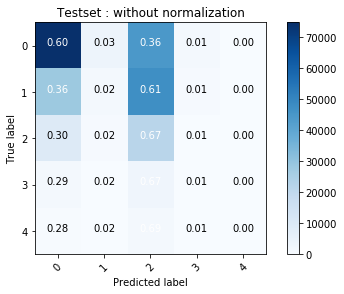

In [39]:
logistic_evaluation(model_path="./logistic_w_1e-3.npy", X_train=X_train, y_train=y_train_one_hot, X_validation=X_valid,
               y_validation=y_vali_one_hot, X_test=X_test, y_test=y_test_one_hot, lambda_v=0)